In [1]:
import pandas as pd
import numpy as np
import mca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
%matplotlib inline
import gc

In [2]:
joined_data = pd.read_csv('C:/Users/Stevens/Desktop/BIA 686/zillow/bia_686/data/train-ml.csv')

In [3]:
def reduce_mem_usage(props):
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)

    mem_usg = props.memory_usage().sum() / 1024**2 
    return props, NAlist

props, NAlist = reduce_mem_usage(joined_data)

In [4]:
## Bed, bath and room are the only variables with significant amout of outliers.  
num_cols = ['bathroomcnt', 'bedroomcnt', 'roomcnt']
num_data = joined_data[num_cols]

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    
    return np.where((ys > upper_bound) | (ys < lower_bound))

out_dict = {}
for col in num_data.columns:
    outlier = outliers_iqr(num_data[col])
    out_dict[col] = outlier
    
out_dict = dict((k, out_dict[k]) for k in ('bathroomcnt','bedroomcnt','roomcnt'))

In [5]:
# only 443 outliers for bedroom - replace with median
bed_ix = (list(list(out_dict['bedroomcnt'])[0]))
bed_median = joined_data.iloc[~joined_data.index.isin(bed_ix)].bedroomcnt.median()
joined_data.loc[(bed_ix), 'bedroomcnt'] = bed_median

In [6]:
# unitcnt extreme outliers
unit_median = joined_data.loc[pd.notnull(joined_data['unitcnt'])]['unitcnt'].median()
joined_data.loc[(joined_data['unitcnt'] > 9), 'unitcnt'] = unit_median

In [7]:
joined_data_sam = joined_data.sample(frac=.15)
train, test = train_test_split(joined_data_sam, test_size=0.2, random_state=4)

In [8]:
del joined_data
del joined_data_sam

gc.collect()

316

In [9]:
X_train = train.drop('logerror', axis=1).values
y_train = train['logerror'].values

In [10]:
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis=0)

In [11]:
X_train = imputer.fit_transform(X_train)

In [12]:
scalar = StandardScaler().fit(X_train)
data_norm = scalar.transform(X_train)

In [13]:
estimator = PCA(n_components=.85, svd_solver='full')
data_pca = estimator.fit(data_norm)

[  6.95  13.09  17.56  21.74  25.46  29.    31.97  34.48  36.92  39.26
  41.47  43.64  45.79  47.9   49.99  51.93  53.84  55.62  57.26  58.86
  60.26  61.62  62.92  64.18  65.41  66.61  67.79  68.95  70.1   71.23
  72.34  73.45  74.55  75.64  76.73  77.81  78.89  79.97  81.04  82.11
  83.17  84.22  85.26]


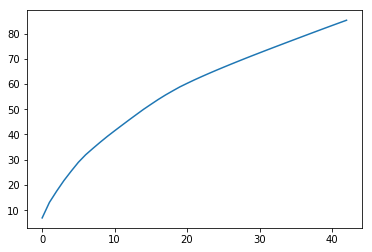

In [14]:
pca_plot = np.cumsum(np.round(data_pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(pca_plot)
print(pca_plot)

In [15]:
X_train = data_pca.transform(data_norm)

In [16]:
rf = RandomForestRegressor(criterion='mae',n_jobs=-1)

In [17]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [18]:
X_test = test.drop('logerror',axis=1).values
X_test = scalar.transform(X_test)
X_test = data_pca.transform(X_test)

In [19]:
y_test = test['logerror'].values

In [20]:
y_preds = rf.predict(X_test)

In [21]:
mean_absolute_error(y_test, y_preds)

0.081448276591045865